In [1]:
from pyspark.sql import SparkSession
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages org.apache.hadoop:hadoop-aws:3.3.4,io.delta:delta-spark_2.12:3.3.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.4,org.apache.kafka:kafka-clients:3.9.0,org.apache.spark:spark-avro_2.12:3.5.1 pyspark-shell"

# Initialize Spark session with Delta Lake and MinIO support
spark = (SparkSession.builder \
    .appName("DeltaLakeWithMinIO") \
    ## Delta
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    #Hive Catalog
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    ## Optimize Delta
    .config("delta.autoOptimize.optimizeWrite", "true") \
    .config("delta.autoOptimize.autoCompact", "true") \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.S3SingleDriverLogStore") \
    ## MinIO
    .config("spark.hadoop.fs.s3a.endpoint", os.getenv("MINIO_ENDPOINT")) \
    .config("spark.hadoop.fs.s3a.access.key", os.getenv("MINIO_ACCESS_KEY")) \
    .config("spark.hadoop.fs.s3a.secret.key", os.getenv("MINIO_SECRET_KEY")) \
    .config('spark.hadoop.fs.s3a.attempts.maximum', "3") \
    .config('spark.hadoop.fs.s3a.connection.timeout', "10000") \
    .config('spark.hadoop.fs.s3a.connection.establish.timeout', "5000") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3n.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate())

your 131072x1 screen size is bogus. expect trouble
25/04/07 16:10:04 WARN Utils: Your hostname, CPC-12806 resolves to a loopback address: 127.0.1.1; using 172.26.242.248 instead (on interface eth0)
25/04/07 16:10:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/arthur/streaming-pipeline/.venv/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/arthur/.ivy2/cache
The jars for the packages stored in: /home/arthur/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
io.delta#delta-spark_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.kafka#kafka-clients added as a dependency
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b5afb897-8db1-4077-8090-b4bac3a89816;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found io.delta#delta-spark_2.12;3.3.0 in central
	found io.delta#delta-storage;3.3.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.4 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.4 in central
	found org.apache.ha

In [2]:
def get_spark_schema():
    with open("../src/schemas/control_power.json") as file:
        avro_schema_str = file.read()

    return avro_schema_str

In [ ]:
from pyspark.sql.functions import current_timestamp, expr
from pyspark.sql.avro.functions import from_avro

# Kafka Configuration
kafka_broker = "kafka-cpc.certi.org.br:31289"
topic_name = "control_power-avro"

# Read data from Kafka
kafka_stream = spark.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", topic_name) \
    .option("startingOffsets", "earliest") \
    .load()

# Deserialize Kafka value (JSON string) into columns
parsed_stream = kafka_stream.select(
        "timestamp",
        from_avro(
            expr("substring(value, 6, length(value)-5)"),
            get_spark_schema()
        ).alias("data")
    ) \
    .select("timestamp", "data.*")

parsed_stream_with_timestamp = parsed_stream.withColumn("landing_timestamp", current_timestamp())

# Output the parsed stream for verification
parsed_stream_with_timestamp.printSchema()


In [ ]:
df = parsed_stream_with_timestamp.toPandas()
df.head()

In [ ]:
import pandas as pd

df["source_timestamp"] = pd.to_datetime(df["source_timestamp"]).dt.tz_convert("America/Sao_Paulo")
df["landing_timestamp"] = df["landing_timestamp"].dt.tz_localize("America/Sao_Paulo")
df["timestamp"] = df["timestamp"].dt.tz_localize("America/Sao_Paulo")
df.head()

In [ ]:
df["source_kafka_latency"] = df["timestamp"] - df["source_timestamp"]
df["source_kafka_latency"].describe()

In [ ]:
import matplotlib.pyplot as plt

# Convert timedelta to seconds for better visualization
df["source_kafka_latency_sec"] = df["source_kafka_latency"].dt.total_seconds()

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(df["source_kafka_latency_sec"], bins=50, edgecolor="black")
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Kafka Source Latency")
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(8, 4))
plt.boxplot(df["source_kafka_latency_sec"], vert=False)
plt.xlabel("Latency (seconds)")
plt.title("Box Plot of Kafka Source Latency")
plt.grid(True)
plt.show()


In [3]:
spark.sql("DESCRIBE delta.`s3a://lakehouse/delta/raw_control_power-avro/`").show()

25/04/07 16:10:10 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+-----------------+--------------------+-------+
|         col_name|           data_type|comment|
+-----------------+--------------------+-------+
|            topic|              string|   NULL|
|        timestamp|           timestamp|   NULL|
|landing_timestamp|           timestamp|   NULL|
|     parsed_value|struct<robot_acti...|   NULL|
+-----------------+--------------------+-------+



In [4]:
spark.sql("SELECT timestamp, landing_timestamp, parsed_value.* FROM delta.`s3a://lakehouse/delta/raw_control_power-avro`;").show(5)

25/04/07 16:10:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+---------------+--------------+--------+---------+-----------+---------+------------+--------------+---------+--------------------+
|           timestamp|   landing_timestamp|robot_action_id|apparent_power| current|frequency|phase_angle|    power|power_factor|reactive_power|  voltage|    source_timestamp|
+--------------------+--------------------+---------------+--------------+--------+---------+-----------+---------+------------+--------------+---------+--------------------+
|2025-04-07 16:01:...|2025-04-07 16:01:...|            8.0|      201.1922|1.050405|     50.0|  327.38892| 169.4784|    0.842371|    -108.41227|232.71596|2025-04-07T19:01:...|
|2025-04-07 16:01:...|2025-04-07 16:01:...|            8.0|     219.84259|1.117593|     50.0|  331.00165|192.28566|    0.874652|     -106.5594| 232.5302|2025-04-07T19:01:...|
|2025-04-07 16:02:...|2025-04-07 16:02:...|           23.0|     184.26695|0.886078|     50.0|  331.04852| 161.2424|    0.8750

In [5]:
df_datalake = spark.sql("SELECT timestamp, landing_timestamp, parsed_value.* FROM delta.`s3a://lakehouse/delta/raw_control_power-avro`;").toPandas()

In [9]:
import pandas as pd

df_datalake["source_timestamp"] = pd.to_datetime(df_datalake["source_timestamp"]).dt.tz_convert("America/Sao_Paulo")
df_datalake["landing_timestamp"] = df_datalake["landing_timestamp"].dt.tz_convert("America/Sao_Paulo")
df_datalake["timestamp"] = df_datalake["timestamp"].dt.tz_convert("America/Sao_Paulo")

df_datalake["source_kafka_latency"] = (df_datalake["timestamp"] - df_datalake["source_timestamp"]).dt.total_seconds()
df_datalake["source_kafka_latency"].describe()

count    23700.000000
mean         0.033967
std          0.126749
min          0.023309
25%          0.027681
50%          0.032548
75%          0.035745
max         18.371924
Name: source_kafka_latency, dtype: float64

In [10]:
df_datalake["kafka_landing_latency"] = (df_datalake["landing_timestamp"] - df_datalake["timestamp"]).dt.total_seconds()
df_datalake["kafka_landing_latency"].describe()

count    23700.000000
mean      1278.693819
std        883.400690
min          0.003000
25%        479.490000
50%       1265.462000
75%       2048.599000
max       2830.989000
Name: kafka_landing_latency, dtype: float64

In [47]:
df_plot = df_datalake.tail(500)

In [48]:
df_plot = df_plot.sort_values("source_timestamp")

23 ms of latency between PC and server at the moment of testing

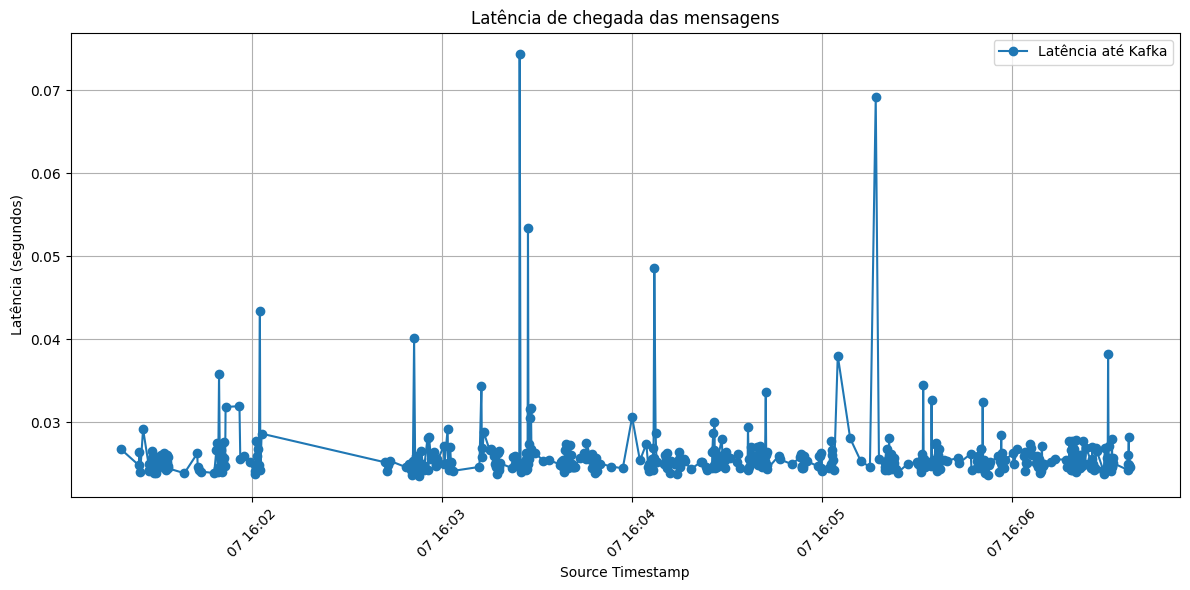

In [49]:
import matplotlib.pyplot as plt

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(df_plot['source_timestamp'], df_plot['source_kafka_latency'], label='Latência até Kafka', marker='o')
plt.xlabel('Source Timestamp')
plt.ylabel('Latência (segundos)')
plt.title('Latência de chegada das mensagens')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Local MinIO used

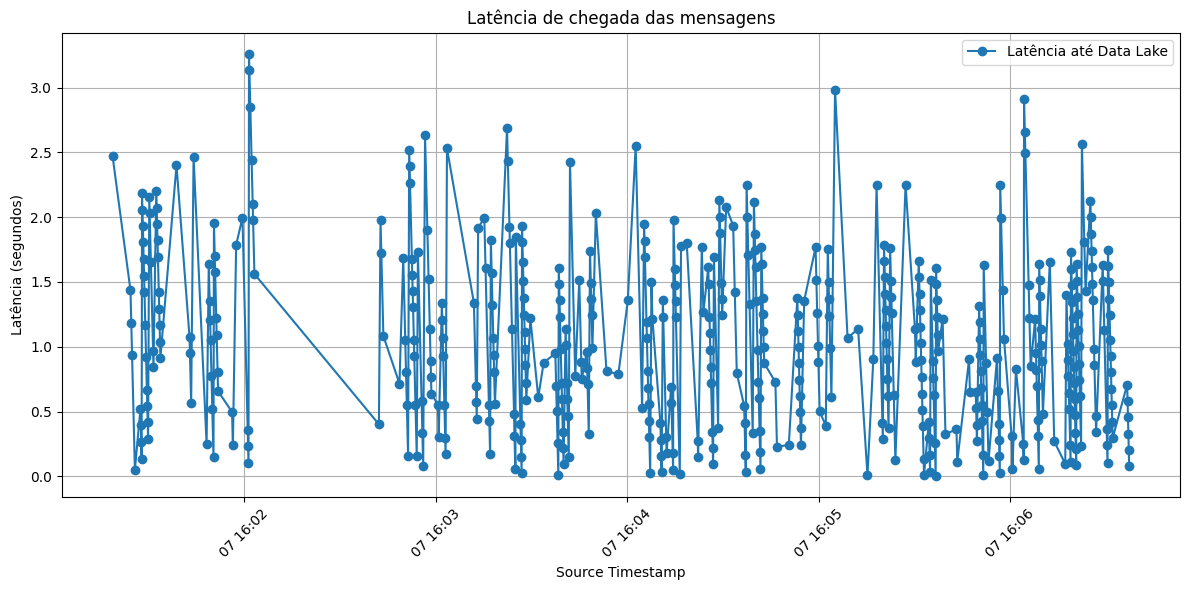

In [50]:
import matplotlib.pyplot as plt

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(df_plot['source_timestamp'], df_plot['kafka_landing_latency'], label='Latência até Data Lake', marker='o')
plt.xlabel('Source Timestamp')
plt.ylabel('Latência (segundos)')
plt.title('Latência de chegada das mensagens')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()